1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


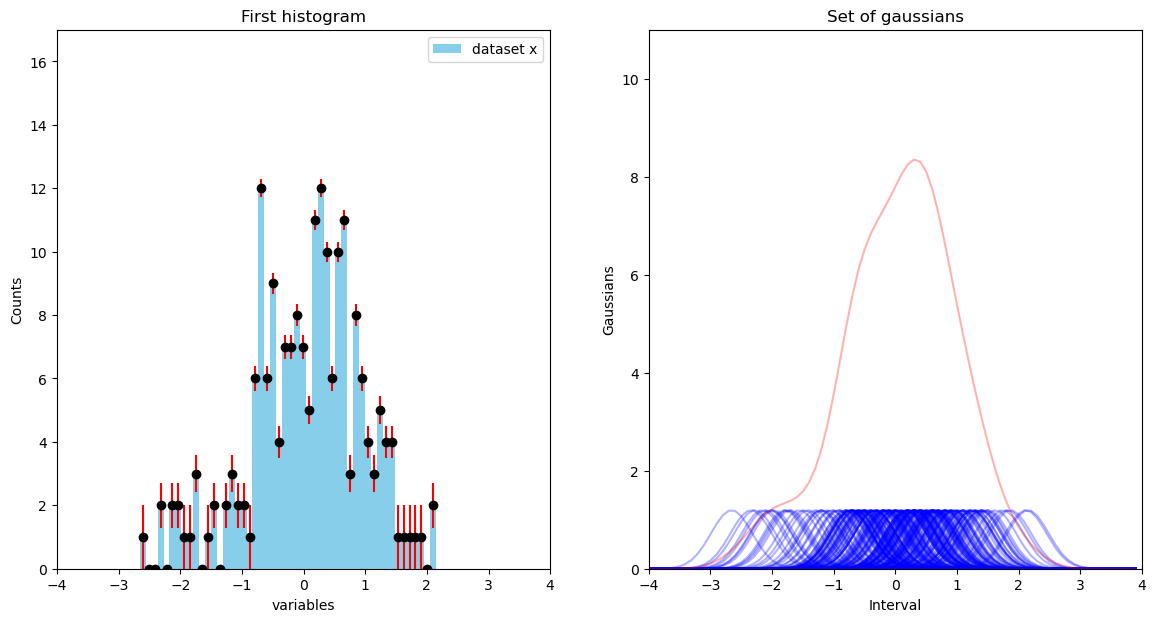

In [45]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.normal(0, 1, 200)

counts, edges = np.histogram(x, bins=50, range=(x.min(), x.max()))

sigma = np.divide(1, np.sqrt(counts), where=(counts!=0)) #stardard deviation (Poisson)
points = (edges[1:] + edges[:-1])/2 #centroids

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

#Histogram
binning = np.linspace(x.min(), x.max(), 51)
ax1.hist(x, bins=binning, label="dataset x", color='skyblue')
ax1.legend()

#Scatter plot
ax1.errorbar(points, counts, yerr=sigma, 
             linestyle='None', marker='o', ecolor='r', markerfacecolor='black', markeredgecolor='black',
             )
ax1.set_xlabel("variables"); ax1.set_ylabel("Counts"); ax1.set_title("First histogram")
ax1.set_xbound(-4, 4); ax1.set_ybound(0, 17)

#New gaussians
from scipy.stats import norm
new_std = 1.06 * x.std() * x.size**(-1/5)
interval = np.arange(-4, 4, 0.1)

#New plot
gauss = np.array([norm.pdf(interval, mean, new_std) for mean in x]) 
for graph in gauss:
    ax2.plot(interval, graph, linestyle='-', color='blue', alpha=0.3)


#Sum and Normalization
from scipy.integrate import trapezoid as trapz
sumofg = np.sum(gauss, axis=0)
histo_int = np.sum(counts*(edges[1]-edges[0]))
sumofg_normalized = sumofg*(histo_int/trapz(sumofg, interval))

#Plot of the sum
ax2.plot(interval, sumofg_normalized, color='red', alpha=0.3)
ax2.set_xlabel("Interval"); ax2.set_ylabel("Gaussians"); ax2.set_title("Set of gaussians")
ax2.set_xbound(-4, 4); ax2.set_ybound(0, 11)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

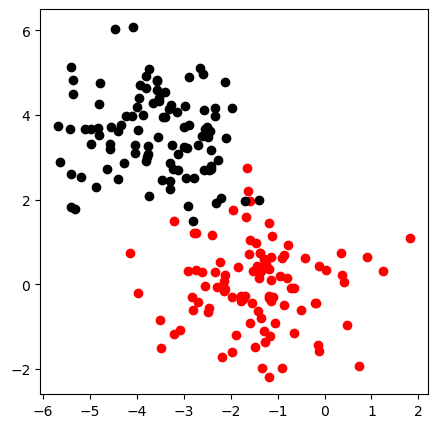

In [81]:
N = 2
means = np.random.uniform(-4, 4, N*2)
datasets = np.array([np.random.normal(mu, 1, 100) for mu in means])

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x=datasets[0], y=datasets[1], marker='o', c='red', edgecolor='red')
ax.scatter(x=datasets[2], y=datasets[3], marker='o', c='black', edgecolor='black')

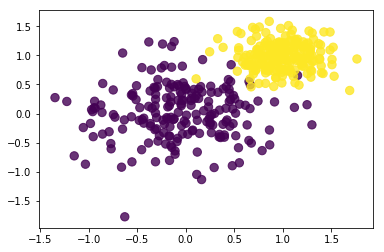

In [47]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

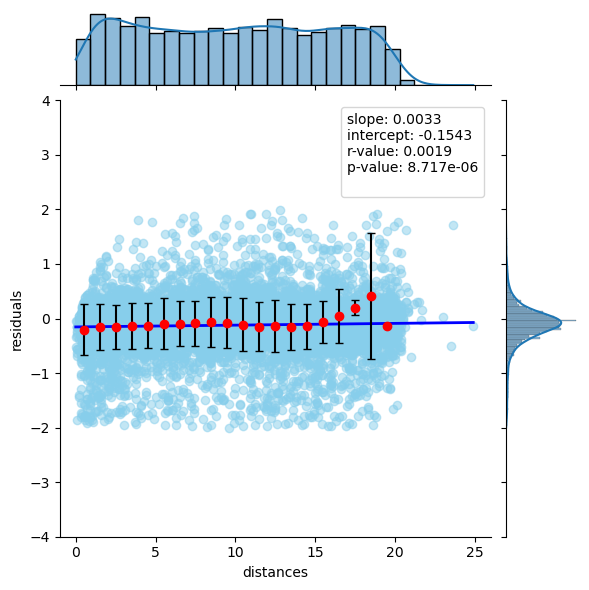

In [ ]:
import pandas as pd
import scipy.stats as scs 
import seaborn as sns 
from matplotlib.patches import Rectangle

df = pd.DataFrame(np.load('residuals_261.npy', allow_pickle=True).item())
selected = df[np.abs(df['residuals']) < 2].copy()

slope, intercept, r_value, p_value, std_err = scs.linregress(x=selected['distances'], y=selected['residuals'])

g = sns.jointplot(
    data=selected, 
    x='distances', y='residuals', 
    kind='reg', 
    scatter_kws={'color': 'skyblue', 'alpha': 0.5}, height=6,
    line_kws={'color': 'blue', 'linewidth': 2},
    xlim=(-1, 26), ylim=(-4,4)
)
reg_stats = (
    f'slope: {slope:.4f}\n'
    f'intercept: {intercept:.4f}\n'
    f'r-value: {r_value**2:.4f}\n'
    f'p-value: {p_value:.3e}\n'
)

g.ax_joint.legend(
    handles=[Rectangle((0, 0), 0, 0, color='none')], # Invisible item
    labels=[reg_stats],                             # Your text
    loc='upper right',                               # Position
    handlelength=0,                                  # Hide handle icon
    handletextpad=0                                  # Remove padding
)

_, edges = np.histogram(selected['distances'], bins=20, range=(0, 20))

x = (edges[1:] + edges[:-1])/2

selected['distance_bins'] = pd.cut(selected['distances'], bins=20)
y = np.array(selected.groupby('distance_bins', observed=False)['residuals'].mean())
erry = np.array(selected.groupby('distance_bins', observed=False)['residuals'].std())

g.ax_joint.errorbar(
    x=x, 
    y=y, 
    yerr=erry, 
    fmt='o',          # 'o' means plot as dots
    color='red',      # Make them distinct
    ecolor='black',   # Color of the error bar lines
    capsize=3,        # Adds little caps to the error bars
)

plt.show()